Import the network library, which is assumed to be someone on the machine. Change the path within the sys.path.append to the location of the library.

In [1]:
import sys
sys.path.append('/path/to/your-library-repo')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from complex_network.networks import network_factory, pole_calculator
from complex_network.networks.network_perturbator import NetworkPerturbator
from complex_network.networks.network_spec import NetworkSpec

Do you want to generate the data from scratch? If False, data will be loaded from saved files. Data generation can be slow, so False is recommended.

In [3]:
generate_data = False

data_directory = (
    "/home/nbyrnes/code/networklibrary/work/ws_paper/network/data/wide_sweep"
)
background_data_location = f"{data_directory}/data.npy"
poles_dict_location = f"{data_directory}/poles_dict.pkl"
pole_shifts_dict_location = f"{data_directory}/pole_shifts_dict.pkl"
poles_dict_negative_location = f"{data_directory}/poles_dict_negative.pkl"
pole_shifts_dict_negative_location = (
    f"{data_directory}/pole_shifts_dict_negative.pkl"
)

Generate the network.

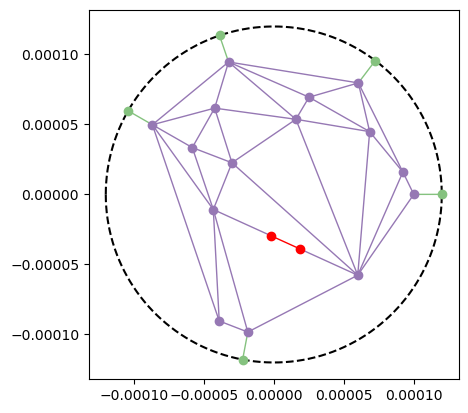

In [4]:
np.random.seed(1)
spec = NetworkSpec(
    network_type="delaunay",
    network_shape="circular",
    num_seed_nodes=0,
    external_offset=0.0,
    num_internal_nodes=15,
    num_external_nodes=5,
    network_size=100e-6,
    external_size=120e-6,
    node_S_mat_type="COE",
    node_S_mat_params={},
)
network = network_factory.generate_network(spec)
network.translate_node(10, np.array([0.00002, -0.00001]))
network.translate_node(6, np.array([0.0000, 0.00001]))
network.add_segment_to_link(9, [0.4, 0.6])
network.draw(
    equal_aspect=True,
    draw_boundary=120e-6,
    highlight_links=[34],
    highlight_nodes=[15, 16],
)

Perform a broad sweep of the (incident wavenumber) complex plane to look for some scattering matrix poles.

In [5]:
d_lam = 2.5e-10
lam_centre = 550e-9
lam_min = lam_centre - d_lam
lam_max = lam_centre + d_lam
max_imag = -2500j
k0_min = 11420692.454866514 - 2500j
k0_max = 11429168.362309389 + 500j
num_points = 1 * 10**3

if generate_data:
    x, y, data = pole_calculator.sweep(k0_min, k0_max, num_points, network)
else:
    k0_reals = np.linspace(k0_min.real, k0_max.real, num_points)
    k0_imags = np.linspace(k0_min.imag, k0_max.imag, num_points)
    x, y = np.meshgrid(k0_reals, k0_imags)
    data = np.load(background_data_location, allow_pickle=True)

Plot the scattering matrix's determinant for the complex wavenumbers.

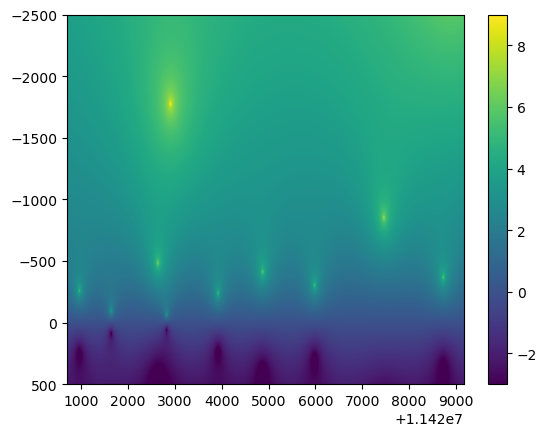

In [6]:
fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data),
    extent=(k0_min.real, k0_max.real, 500, max_imag.imag),
    aspect="auto",
    vmin=-3,
    vmax=9,
)
cbar = fig.colorbar(im)

Hone in on the poles identified in the previous figure.

In [7]:
pole_guesses = 1.142e7 + np.array(
    [
        1000 - 300j,
        1500 - 100j,
        2500 - 500j,
        2500 - 100j,
        3000 - 1750j,
        4000 - 200j,
        5000 - 400j,
        6000 - 300j,
        7500 - 900j,
        8500 - 400j,
    ]
)
poles = np.array(
    [pole_calculator.find_pole(network, guess) for guess in pole_guesses]
)

Calculate the pole shift data for a series of refractive index perturbations.

In [8]:
link_index = 34

if generate_data:
    # Positive refractive index perturbations
    perturbator = NetworkPerturbator(network)
    dn_values = np.hstack(([0.0], np.linspace(1e-4, 2e-1, 2500)))

    poles_dict, pole_shifts_dict = perturbator.track_pole_segment_n(
        poles, link_index, dn_values
    )

    # Negative refractive index perturbations
    perturbator = NetworkPerturbator(network)
    dn_values = np.hstack(([0.0] + np.linspace(-1e-4, -2e-1, 2500)))
    poles_dict_negative, pole_shifts_dict_negative = (
        perturbator.track_pole_segment_n(poles, link_index, dn_values)
    )
else:
    with open(poles_dict_location, "rb") as f:
        poles_dict = pickle.load(f)
    with open(pole_shifts_dict_location, "rb") as f:
        pole_shifts_dict = pickle.load(f)
    with open(poles_dict_negative_location, "rb") as f:
        poles_dict_negative = pickle.load(f)
    with open(pole_shifts_dict_negative_location, "rb") as f:
        pole_shifts_dict_negative = pickle.load(f)

Plot the poles and pole trajectories.

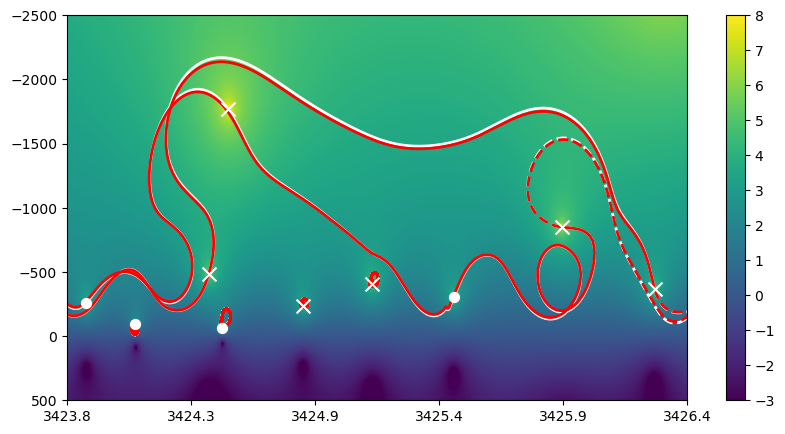

In [9]:
size_x = 10
size_y = 5
fig, ax = plt.subplots(figsize=(size_x, size_y))

# Set graph limits
graph_x_min = k0_min.real
graph_x_max = k0_max.real
graph_y_min = 500
graph_y_max = max_imag.imag
ax.set_xlim(graph_x_min, graph_x_max)
ax.set_ylim(graph_y_min, graph_y_max)

num_x_ticks = 6
c = 299792458
k_ticks = [
    graph_x_min + (graph_x_max - graph_x_min) * i / (num_x_ticks - 1)
    for i in range(num_x_ticks)
]
w_ticks = [k_tick * c / 1e12 for k_tick in k_ticks]
w_ticklabels = [f"{w_tick:.1f}" for w_tick in w_ticks]
ax.set_xticks(k_ticks)
ax.set_xticklabels(w_ticklabels)

# Background plot
plot_data = np.flip(data, axis=1)
vmax = 8
vmin = -3
im = ax.imshow(
    -np.log(data),
    extent=(graph_x_min, graph_x_max, graph_y_min, graph_y_max),
    aspect="auto",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
)
cbar = fig.colorbar(im)
cbar_ticks = range(vmin, vmax + 1)
cbar.set_ticks(cbar_ticks)

# Solid lines for positive perturbations
indices = [2, 4, 5, 6, 8, 9]
for line_type, color in zip(["direct", "volume"], ["white", "red"]):
    for i, poles_list in enumerate(np.array(poles_dict[line_type])[indices]):
        xs = np.array(poles_list).real
        ys = np.array(poles_list).imag
        ax.plot(xs, ys, color=color, label=line_type, linewidth=2)

# Dashed lines for negative perturbations
indices_negative = [8, 9]
for line_type, color in zip(["direct", "volume"], ["white", "red"]):
    for i, poles_list in enumerate(
        np.array(poles_dict_negative[line_type])[indices_negative]
    ):
        xs = np.array(poles_list).real
        ys = np.array(poles_list).imag
        ax.plot(
            xs, ys, color=color, label=line_type, linewidth=2, linestyle="--"
        )

# Pole markers
ax.scatter(
    np.real(poles)[indices],
    np.imag(poles)[indices],
    color="white",
    marker="x",
    s=100,
    zorder=3,
)
remaining_indices = [0, 1, 3, 7]
ax.scatter(
    np.real(poles)[remaining_indices],
    np.imag(poles)[remaining_indices],
    color="white",
    marker="o",
    s=50,
    zorder=3,
)

Generate background data for smaller plots. These numbers were found empirically.

In [10]:
# First
one_centre = 1.142e7 + 1625 + -50j
one_half_width = 100
bottom_left_one = one_centre - 1.5 * one_half_width + one_half_width * 1j
bottom_right_one = one_centre + 1.5 * one_half_width + one_half_width * 1j
top_right_one = one_centre + 1.5 * one_half_width - one_half_width * 1j
top_left_one = one_centre - 1.5 * one_half_width - one_half_width * 1j
k0_min_zoom1 = bottom_left_one
k0_max_zoom1 = top_right_one
num_points_zoom1 = 2 * 10**2
x_zoom1, y_zoom1, data_zoom1 = pole_calculator.sweep(
    k0_min_zoom1, k0_max_zoom1, num_points_zoom1, network
)

# Second
two_centre = 1.142e7 + 3935 - 250j
two_half_width = 100
bottom_left_two = two_centre - 1.5 * two_half_width + two_half_width * 1j
bottom_right_two = two_centre + 1.5 * two_half_width + two_half_width * 1j
top_right_two = two_centre + 1.5 * two_half_width - two_half_width * 1j
top_left_two = two_centre - 1.5 * two_half_width - two_half_width * 1j
k0_min_zoom2 = bottom_left_two
k0_max_zoom2 = top_right_two
num_points_zoom2 = 2 * 10**2
x_zoom2, y_zoom2, data_zoom2 = pole_calculator.sweep(
    k0_min_zoom2, k0_max_zoom2, num_points_zoom2, network
)

# Third
three_centre = 1.142e7 + 5900 - 225j
three_half_width = 100
bottom_left_three = (
    three_centre - 1.5 * three_half_width + three_half_width * 1j
)
bottom_right_three = (
    three_centre + 1.5 * three_half_width + three_half_width * 1j
)
top_right_three = three_centre + 1.5 * three_half_width - three_half_width * 1j
top_left_three = three_centre - 1.5 * three_half_width - three_half_width * 1j
k0_min_zoom3 = bottom_left_three
k0_max_zoom3 = top_right_three
num_points_zoom3 = 2 * 10**2
x_zoom3, y_zoom3, data_zoom3 = pole_calculator.sweep(
    k0_min_zoom3, k0_max_zoom3, num_points_zoom3, network
)

# Fourth
four_centre = 1.142e7 + 7550 - 200j
four_half_width = 100
bottom_left_four = four_centre - 1.5 * four_half_width + four_half_width * 1j
bottom_right_four = four_centre + 1.5 * four_half_width + four_half_width * 1j
top_right_four = four_centre + 1.5 * four_half_width - four_half_width * 1j
top_left_four = four_centre - 1.5 * four_half_width - four_half_width * 1j
k0_min_zoom4 = bottom_left_four
k0_max_zoom4 = top_right_four
num_points_zoom4 = 2 * 10**2
x_zoom4, y_zoom4, data_zoom4 = pole_calculator.sweep(
    k0_min_zoom4, k0_max_zoom4, num_points_zoom4, network
)

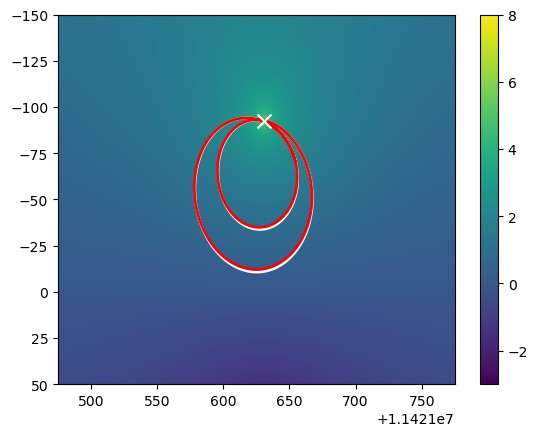

In [11]:
# Plot the initial pole landscape
fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data_zoom1),
    extent=(
        k0_min_zoom1.real,
        k0_max_zoom1.real,
        k0_max_zoom1.imag,
        k0_min_zoom1.imag,
    ),
    aspect="auto",
    vmin=vmin,
    vmax=vmax,
)
ax.set_xlim(bottom_left_one.real, bottom_right_one.real)
ax.set_ylim(bottom_left_one.imag, top_left_one.imag)
cbar = fig.colorbar(im)

indices = [1, 2, 3, 4, 5, 6, 8, 9]
index = 350
for line_type, color in zip(["direct", "volume"], ["white", "red"]):
    for i, poles_list in enumerate(np.array(poles_dict[line_type])[indices]):
        xs = np.array([p.real for p in poles_list])[0:484]
        ys = np.array([p.imag for p in poles_list])[0:484]

        ax.plot(
            xs[:index],
            ys[:index],
            color=color,
            label=line_type,
            linewidth=2,
        )

ax.scatter(
    np.real(poles)[indices],
    np.imag(poles)[indices],
    color="white",
    marker="x",
    s=100,
    zorder=3,
)

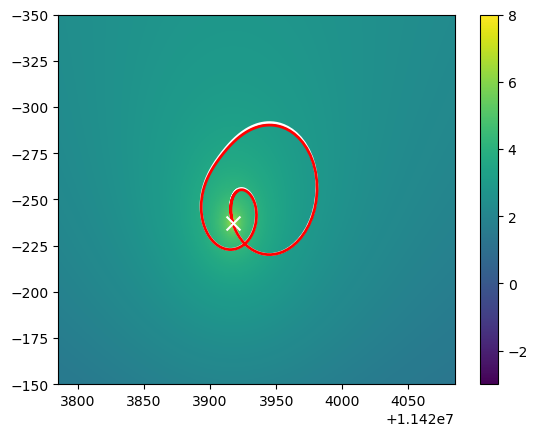

In [12]:
# Plot the initial pole landscape
plot_data = np.flip(data, axis=1)

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data_zoom2),
    extent=(
        k0_min_zoom2.real,
        k0_max_zoom2.real,
        k0_max_zoom2.imag,
        k0_min_zoom2.imag,
    ),
    aspect="auto",
    vmin=vmin,
    vmax=vmax,
)
ax.set_xlim(bottom_left_two.real, bottom_right_two.real)
ax.set_ylim(bottom_left_two.imag, top_left_two.imag)
cbar = fig.colorbar(im)

indices = [1, 2, 3, 4, 5, 6, 8, 9]

for line_type, color in zip(["direct", "volume"], ["white", "red"]):
    for i, poles_list in enumerate(np.array(poles_dict[line_type])[indices]):
        xs = np.array([p.real for p in poles_list])[:484]
        ys = np.array([p.imag for p in poles_list])[:484]

        ax.plot(
            xs[:index], ys[:index], color=color, label=line_type, linewidth=2
        )
ax.scatter(
    np.real(poles)[indices],
    np.imag(poles)[indices],
    color="white",
    marker="x",
    s=100,
    zorder=3,
)

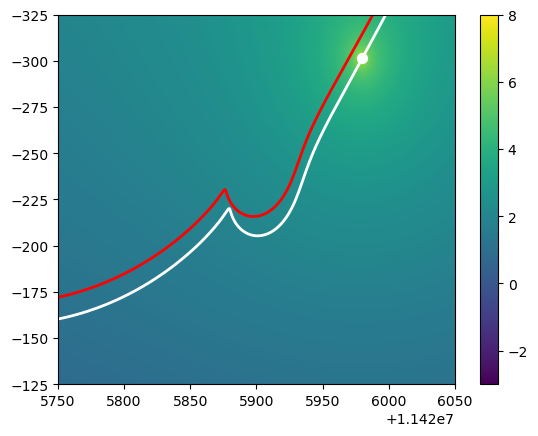

In [13]:
# Plot the initial pole landscape
plot_data = np.flip(data, axis=1)

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data_zoom3),
    extent=(
        k0_min_zoom3.real,
        k0_max_zoom3.real,
        k0_max_zoom3.imag,
        k0_min_zoom3.imag,
    ),
    aspect="auto",
    vmin=vmin,
    vmax=vmax,
)
ax.set_xlim(bottom_left_three.real, bottom_right_three.real)
ax.set_ylim(bottom_left_three.imag, top_left_three.imag)
cbar = fig.colorbar(im)

indices = [1, 2, 3, 4, 5, 6, 8, 9]
index = -1
for line_type, color in zip(["direct", "volume"], ["white", "red"]):
    for i, poles_list in enumerate(np.array(poles_dict[line_type])[indices]):
        xs = np.array([p.real for p in poles_list])
        ys = np.array([p.imag for p in poles_list])

        ax.plot(
            xs[:index], ys[:index], color=color, label=line_type, linewidth=2
        )

ax.scatter(
    np.real(poles)[7],
    np.imag(poles)[7],
    color="white",
    marker="o",
    s=50,
    zorder=3,
)

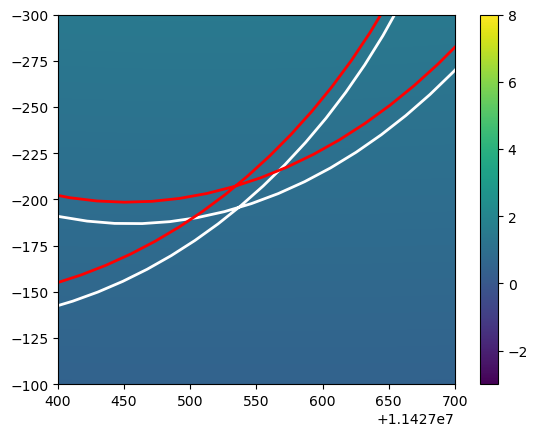

In [14]:
# Plot the initial pole landscape
plot_data = np.flip(data, axis=1)

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data_zoom4),
    extent=(
        k0_min_zoom4.real,
        k0_max_zoom4.real,
        k0_max_zoom4.imag,
        k0_min_zoom4.imag,
    ),
    aspect="auto",
    vmin=vmin,
    vmax=vmax,
)
ax.set_xlim(bottom_left_four.real, bottom_right_four.real)
ax.set_ylim(bottom_left_four.imag, top_left_four.imag)
cbar = fig.colorbar(im)

indices = [1, 2, 3, 4, 5, 6, 8, 9]

for line_type, color in zip(["direct", "volume"], ["white", "red"]):
    for i, poles_list in enumerate(np.array(poles_dict[line_type])[indices]):
        xs = np.array([p.real for p in poles_list])
        ys = np.array([p.imag for p in poles_list])

        ax.plot(
            xs[:index], ys[:index], color=color, label=line_type, linewidth=2
        )

Pumping experiment data and plots.

Reset the network.

In [15]:
# Generate the random network
np.random.seed(1)
spec = NetworkSpec(
    network_type="delaunay",
    network_shape="circular",
    num_seed_nodes=0,
    external_offset=0.0,
    num_internal_nodes=15,
    num_external_nodes=5,
    network_size=100e-6,
    external_size=120e-6,
    node_S_mat_type="COE",
    node_S_mat_params={},
)
network = network_factory.generate_network(spec)
network.translate_node(10, np.array([0.00002, -0.00001]))
network.translate_node(6, np.array([0.0000, 0.00001]))

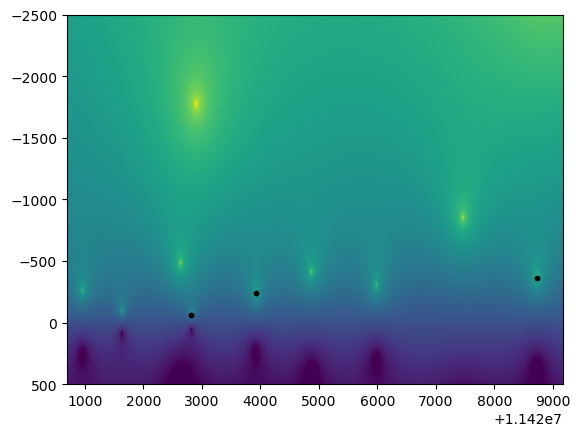

In [16]:
sorted_poles = sorted(poles, key=lambda x: -x.imag)
target_poles = np.array(sorted_poles)[[0, 2, 5]]
# Plot the initial pole landscape
fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data),
    extent=(k0_min.real, k0_max.real, 500, max_imag.imag),
    aspect="auto",
    vmin=-3,
    vmax=9,
)
ax.scatter(np.real(target_poles), np.imag(target_poles), color="black", s=10)

Uniform network pump.

In [17]:
# Uniform network pumping starts here
Dn_values = np.linspace(0, -1e-3j, 50)

perturbator = NetworkPerturbator(network)
poles_dict, pole_shifts_dict = perturbator.track_pole_uniform_pump(
    target_poles, Dn_values
)

100%|██████████| 49/49 [02:41<00:00,  3.30s/it]


Targeted network pump.

In [18]:
link_dicts = []
pumped_links = [21, 26]

for pumped_link in pumped_links:
    perturbator = NetworkPerturbator(network)
    poles_dict_link, pole_shifts_dict_link = (
        perturbator.track_pole_selective_pump(
            pumped_link, target_poles, Dn_values
        )
    )
    link_dicts.append(poles_dict_link)

100%|██████████| 49/49 [00:28<00:00,  1.75it/s]


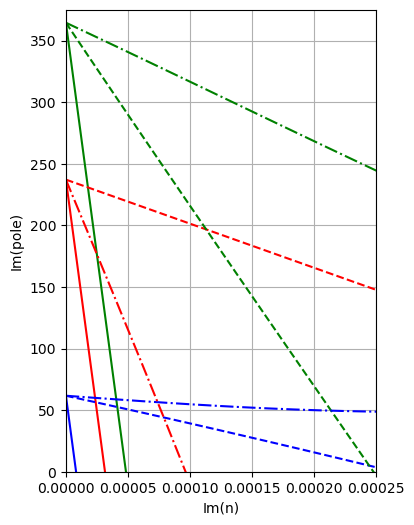

In [19]:
fig, ax = plt.subplots(figsize=(4, 6))
ax.set_ylim(0, 375)
ax.set_xlim(0, 0.00025)
ax.set_xlabel("Im(n)")
ax.set_ylabel("Im(pole)")
# ax.set_xticks([0.0, 0.00005, 0.0001, 0.00015, 0.0002])
ax.grid()

colors = ["blue", "red", "green", "tab:red", "tab:purple"]
linestyles = ["dashed", "dashdot"]

# Uniform pump
for i, p in enumerate(np.array(poles_dict["direct"])):
    color = colors[i]
    ax.plot(-np.imag(Dn_values), -np.imag(p), color=color)


for pumped_link, dict, linestyle in zip(
    np.array(pumped_links)[[0, 1]],
    np.array(link_dicts)[[0, 1]],
    linestyles,
):
    for i, p in enumerate(np.array(dict["direct"])[0:5]):
        color = colors[i]
        ax.plot(
            -np.imag(Dn_values), -np.imag(p), color=color, linestyle=linestyle
        )

Mode distribution plots.

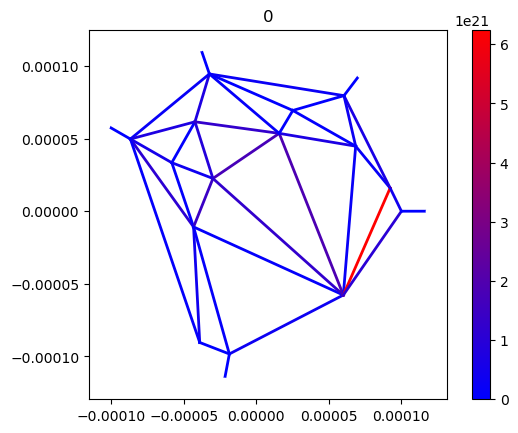

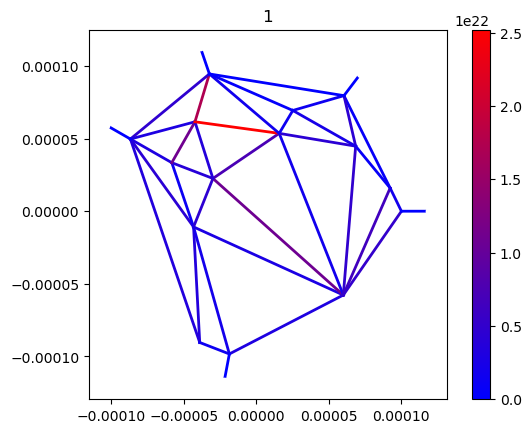

In [20]:
# Loop poles
for i, pole in enumerate(target_poles[[1, 2]]):
    incident_field = np.array([1, 0, 0, 0, 0])
    network.scatter_direct(incident_field, pole)
    network.plot_internal(pole, title=f"{i}", lw=2.0)